In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import json
import ast
from matplotlib.ticker import FuncFormatter
import glob
from matplotlib import animation
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import scipy
from scipy.stats import entropy
from sklearn import manifold
from adjustText import adjust_text
from mpl_toolkits import mplot3d
import networkx as nx

In [2]:
#plt.style.use('seaborn-white')
plt.style.use('seaborn')
# for matplotlib xkcd I need to install new font without root, like this: 
#https://community.linuxmint.com/tutorial/view/29
# and then ivalidate cache like this: 
#https://stackoverflow.com/questions/19663986/getting-xkcd-plots-using-matplotlib/22812176#22812176
# or by deleting by: rm ~/.cache/matplotlib -r
# the font ttf file must be in ~/.fonts/fonts/truetype/humor-sans directory

# to recover from xkcd
#mpl.rcParams.update(saved_state)

# to save state and go to xkcd
#saved_state = mpl.rcParams.copy()
#plt.xkcd()

from matplotlib import rcParams
rcParams['font.family'] = 'Calibri'

conf = {
    'font.size': 14.0,
    'figure.titlesize': 'x-large',
    'axes.titlesize': 'x-large',
    'axes.labelsize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
    'legend.fontsize': 'medium',
}

plt.rcParams.update(conf)


In [3]:
# showing all available font
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [4]:
animes = pd.read_csv('anime_cleaned.csv')
users = pd.read_csv('users_cleaned.csv')
animelists = pd.read_csv('animelists_cleaned.csv')

In [5]:
animes = pd.read_csv('anime_filtered.csv')


In [6]:
users['birth_date'] = pd.to_datetime(users['birth_date'])
users['last_online'] = pd.to_datetime(users['last_online'])
users['join_date'] = pd.to_datetime(users['join_date'])
animelists['my_last_updated'] = pd.to_datetime(animelists['my_last_updated'])
# renaming possibly array-like columns to end with -s
animes = animes.rename(columns={'genre': 'genres', 'studio': 'studios'})

In [7]:
# setting index for primary identifiers
animes = animes.set_index('anime_id')
users = users.set_index('username')


In [8]:
# manually calculating airing year
animes['aired_from_year'] = pd.to_datetime(animes['aired'].apply(lambda x: ast.literal_eval(x.replace('\'', '"'))['from']), errors='coerce').dt.year
# now, for anime with airing year in aired_string column, I use that year to fill aired_from_year
years_from_string = animes['aired_string'].str.extract(r'(\d{4})')
animes.loc[animes['aired_from_year'].isnull(), 'aired_from_year'] = years_from_string[animes['aired_from_year'].isnull()]

/home.stud/racinmat/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


In [9]:
# not I get only animes with airing year
animes = animes[~animes['aired_from_year'].isnull()]
animes['aired_from_year'] = animes['aired_from_year'].astype(np.int)

In [10]:
animes['genres'].fillna('', inplace=True)
genres_arr = animes['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
genres_arr.index.levels[0].name = 'anime_id'
animes_genres = pd.merge(animes, genres_arr, how='left', left_index=True, right_index=True)

In [11]:
shonen_ai = animes_genres['genre'] == 'ShounenAi'
yaoi = animes_genres['genre'] == 'Yaoi'
shonen_ai_or_yaoi = shonen_ai | yaoi

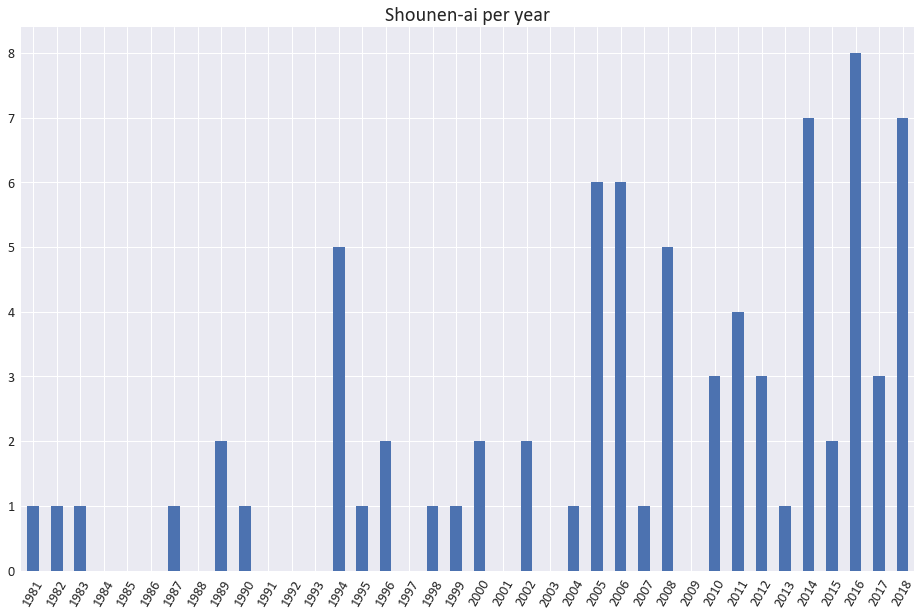

In [12]:
min_year = int(animes_genres[shonen_ai]['aired_from_year'].min())
max_year = int(animes_genres[shonen_ai]['aired_from_year'].max())
shonen_ai_years = animes_genres[shonen_ai]['aired_from_year'].value_counts()
shonen_ai_years.index = shonen_ai_years.index.astype(np.int)
shonen_ai_years = shonen_ai_years.reindex(list(range(min_year, max_year + 1)), fill_value=0)
shonen_ai_years.sort_index().plot.bar(figsize=(16, 10), title='Shounen-ai per year')
plt.xticks(rotation=60)
plt.savefig('graphs-nagat/shounen-ai-per-year.png', bbox_inches="tight")

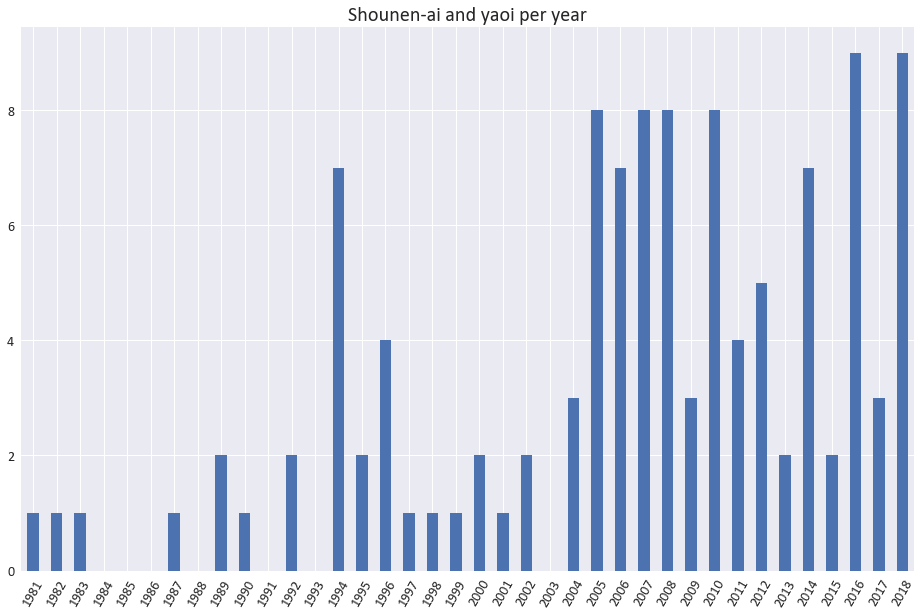

In [13]:
min_year = int(animes_genres[shonen_ai_or_yaoi]['aired_from_year'].min())
max_year = int(animes_genres[shonen_ai_or_yaoi]['aired_from_year'].max())
shonen_ai_yaoi_years = animes_genres[shonen_ai_or_yaoi]['aired_from_year'].value_counts()
shonen_ai_yaoi_years.index = shonen_ai_yaoi_years.index.astype(np.int)
shonen_ai_yaoi_years = shonen_ai_yaoi_years.reindex(list(range(min_year, max_year + 1)), fill_value=0)
shonen_ai_yaoi_years.sort_index().plot.bar(figsize=(16, 10), title='Shounen-ai and yaoi per year')
plt.xticks(rotation=60)
plt.savefig('graphs-nagat/shounen-ai-and-yaoi-per-year.png', bbox_inches="tight")

In [14]:
animes_genres[shonen_ai]['aired_from_year'].value_counts().index.astype(np.int)

Int64Index([2016, 2018, 2014, 2006, 2005, 2008, 1994, 2011, 2012, 2010, 2017,
            1989, 2015, 1996, 2002, 2000, 1983, 1987, 1982, 1990, 2004, 1995,
            1998, 1999, 2007, 2013, 1981],
           dtype='int64')

In [15]:
animes_genres[shonen_ai].head()

,,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,...,broadcast,related,producer,licensor,studios,genres,opening_theme,ending_theme,aired_from_year,genre
anime_id,,,,,,,,,,,,,,,,,,,,,,
4814,3,Junjou Romantica 2,Junjo Romantica 2,純情ロマンチカ2(に),"Junjou Romantica Second Season, Junjyou Romant...",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,...,Unknown,"{'Adaptation': [{'mal_id': 765, 'type': 'manga...","Frontier Works, Kadokawa Shoten, Memory-Tech, ...",Nozomi Entertainment,Studio Deen,"Comedy, Drama, Romance, Shounen Ai","['""Shōdō (衝動)"" by Pigstar']","['""Aioi (相生-アイオイ-)"" by JUNED']",2008,ShounenAi
11123,3,Sekaiichi Hatsukoi 2,Sekai Ichi Hatsukoi - World&#039;s Greatest Fi...,世界一初恋 2,"Sekai-ichi Hatsukoi 2, Sekai&#039;ichi Hatsukoi 2",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,...,Unknown,"{'Adaptation': [{'mal_id': 10309, 'type': 'man...","Lantis, Kadokawa Shoten, AT-X, KlockWorx",Funimation,Studio Deen,"Comedy, Drama, Romance, Shounen Ai","['""Sekai no Hate ni Kimi ga Itemo"" (世界の果てに君がいて...","['""Aikotoba"" (アイコトバ) by Sakura Merry-Men']",2011,ShounenAi
9926,3,Sekaiichi Hatsukoi,Sekai Ichi Hatsukoi - World&#039;s Greatest Fi...,世界一初恋 TV,"Sekai-ichi Hatsukoi, Sekai&#039;ichi Hatsukoi,...",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,...,Unknown,"{'Adaptation': [{'mal_id': 10573, 'type': 'man...","Lantis, Kadokawa Shoten, AT-X, DAX Production,...",Funimation,Studio Deen,"Comedy, Drama, Romance, Shounen Ai","['""Sekai de Ichiban Koishiteru (世界で一番恋してる)"" by...","['""Ashita, Boku wa Kimi ni Ai ni Iku. (明日、僕は君に...",2011,ShounenAi
3092,3,Junjou Romantica,Junjo Romantica,純情ロマンチカ,"Junjyou Romantica, Junjou Romantica: Pure Romance",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,...,Unknown,"{'Adaptation': [{'mal_id': 765, 'type': 'manga...","Frontier Works, Kadokawa Shoten, Memory-Tech, ...",Nozomi Entertainment,Studio Deen,"Comedy, Drama, Romance, Shounen Ai","['""Kimi = Hana (君＝花)"" by pigstar']","['""Baby Romantica (ベイビーロマンチカ)"" by SCRIPT']",2008,ShounenAi
1640,5,Angel&#039;s Feather,Angel&#039;s Feather,エンジェルズフェザー Angel&#039;s Feather,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Visual novel,2,Finished Airing,False,...,NaN,[],NaN,Media Blasters,Venet,"Sci-Fi, Supernatural, Drama, Romance, Fantasy,...","['""ROCK STAR"" by Kakihara Tetsuya & Hatano Wat...","['""LAST SONG"" by Ishikawa Hideo & Suzuki Chihi...",2006,ShounenAi


In [16]:
animes_genres[shonen_ai].columns

Index(['title', 'title_english', 'title_japanese', 'title_synonyms',
       'image_url', 'type', 'source', 'episodes', 'status', 'airing',
       'aired_string', 'aired', 'duration', 'rating', 'score', 'scored_by',
       'rank', 'popularity', 'members', 'favorites', 'background', 'premiered',
       'broadcast', 'related', 'producer', 'licensor', 'studios', 'genres',
       'opening_theme', 'ending_theme', 'aired_from_year', 'genre'],
      dtype='object')

In [17]:
genres_arr = animes['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre').reset_index().drop(['level_1'], axis=1)
animelists_genres = pd.merge(animelists, genres_arr, how='left', on='anime_id')

In [18]:
users_shounenai = animelists_genres[animelists_genres['genre'] == 'ShounenAi'].groupby('username')['genre'].count()

In [19]:
animelists_genres_years = pd.merge(animelists_genres, animes['aired_from_year'].astype(np.int).to_frame(name='aired_from_year').reset_index(), how='left', on='anime_id')

In [20]:
shonen_ai_list = animelists_genres_years['genre'] == 'ShounenAi'
yaoi_list = animelists_genres_years['genre'] == 'Yaoi'
shonen_ai_or_yaoi_list = shonen_ai_list | yaoi_list

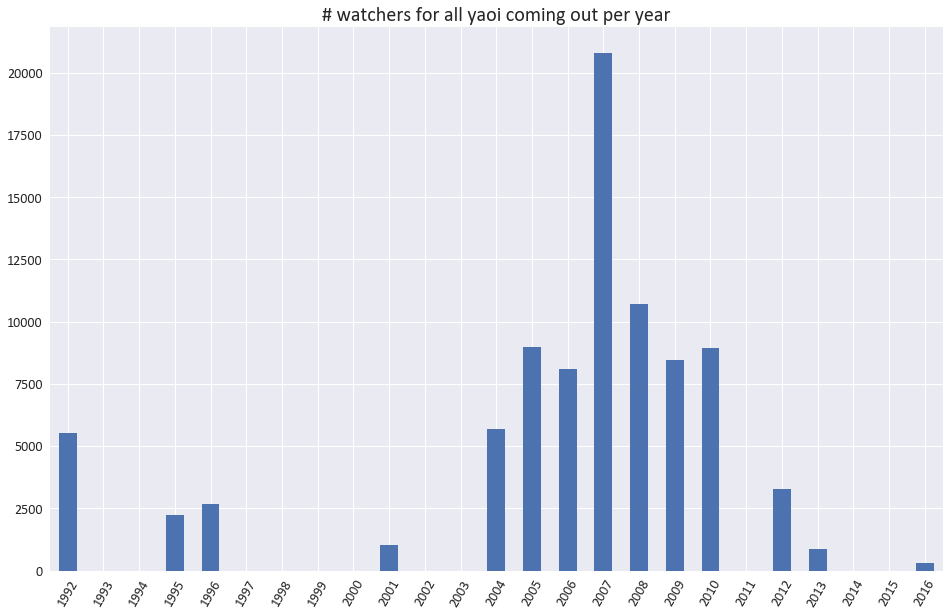

In [21]:
min_year = animelists_genres_years[yaoi_list]['aired_from_year'].min()
max_year = animelists_genres_years[yaoi_list]['aired_from_year'].max()
yaoi_ratings_years = animelists_genres_years[yaoi_list]['aired_from_year'].value_counts()
yaoi_ratings_years.index = yaoi_ratings_years.index.astype(np.int)
yaoi_ratings_years = yaoi_ratings_years.reindex(list(range(min_year, max_year + 1)), fill_value=0)
yaoi_ratings_years.sort_index().plot.bar(figsize=(16, 10), title='# watchers for all yaoi coming out per year')
plt.xticks(rotation=60)
plt.savefig('graphs-nagat/num-watchers-per-year.png', bbox_inches="tight")

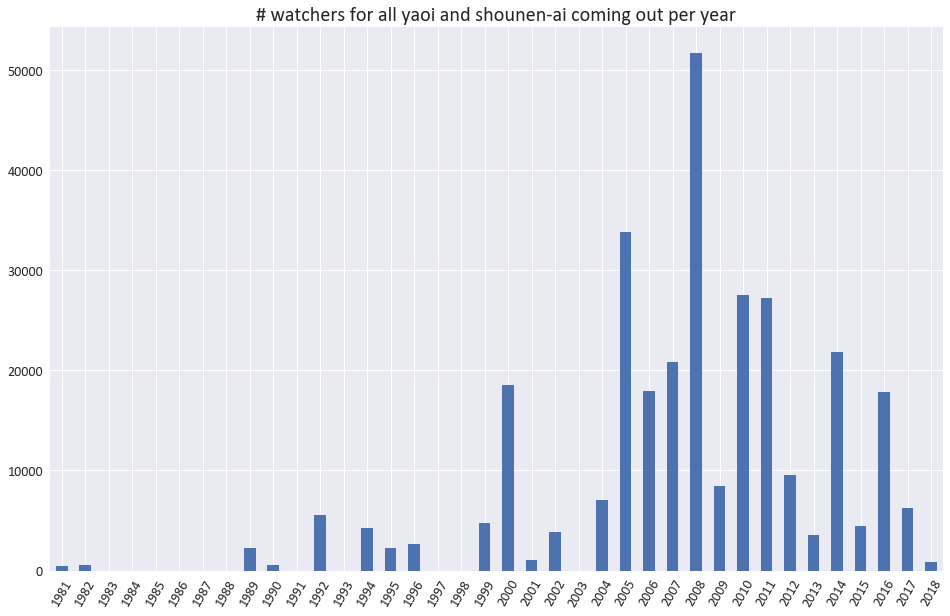

In [22]:
min_year = animelists_genres_years[shonen_ai_or_yaoi_list]['aired_from_year'].min()
max_year = animelists_genres_years[shonen_ai_or_yaoi_list]['aired_from_year'].max()
shonen_ai_or_yaoi_ratings_years = animelists_genres_years[shonen_ai_or_yaoi_list]['aired_from_year'].value_counts()
shonen_ai_or_yaoi_ratings_years.index = shonen_ai_or_yaoi_ratings_years.index.astype(np.int)
shonen_ai_or_yaoi_ratings_years = shonen_ai_or_yaoi_ratings_years.reindex(list(range(min_year, max_year + 1)), fill_value=0)
shonen_ai_or_yaoi_ratings_years.sort_index().plot.bar(figsize=(16, 10), title='# watchers for all yaoi and shounen-ai coming out per year')
plt.xticks(rotation=60)
plt.savefig('graphs-nagat/num-watchers-yaoi-and-shounen-ai-per-year.png', bbox_inches="tight")

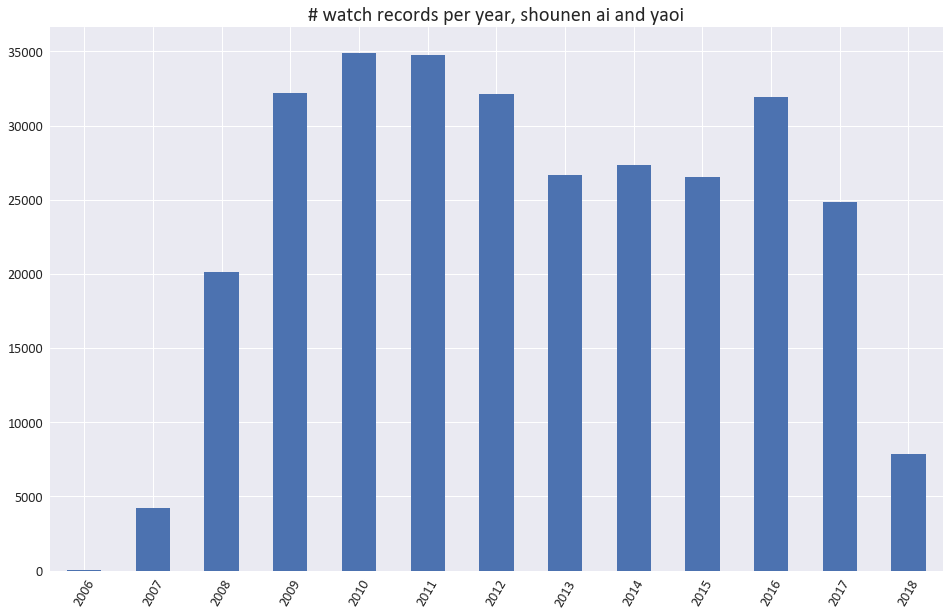

In [23]:
min_year = 2006  ## hardcoded MAL minimum
max_year = animelists_genres_years[shonen_ai_or_yaoi_list]['my_last_updated'].dt.year.max()
shonen_ai_or_yaoi_ratings_years = animelists_genres_years[shonen_ai_or_yaoi_list]['my_last_updated'].dt.year.value_counts()
shonen_ai_or_yaoi_ratings_years.index = shonen_ai_or_yaoi_ratings_years.index.astype(np.int)
shonen_ai_or_yaoi_ratings_years = shonen_ai_or_yaoi_ratings_years.reindex(list(range(min_year, max_year + 1)), fill_value=0)
shonen_ai_or_yaoi_ratings_years.sort_index().plot.bar(figsize=(16, 10), title='# watch records per year, shounen ai and yaoi')
plt.xticks(rotation=60)
plt.savefig('graphs-nagat/watch-records-per-year.png', bbox_inches="tight")

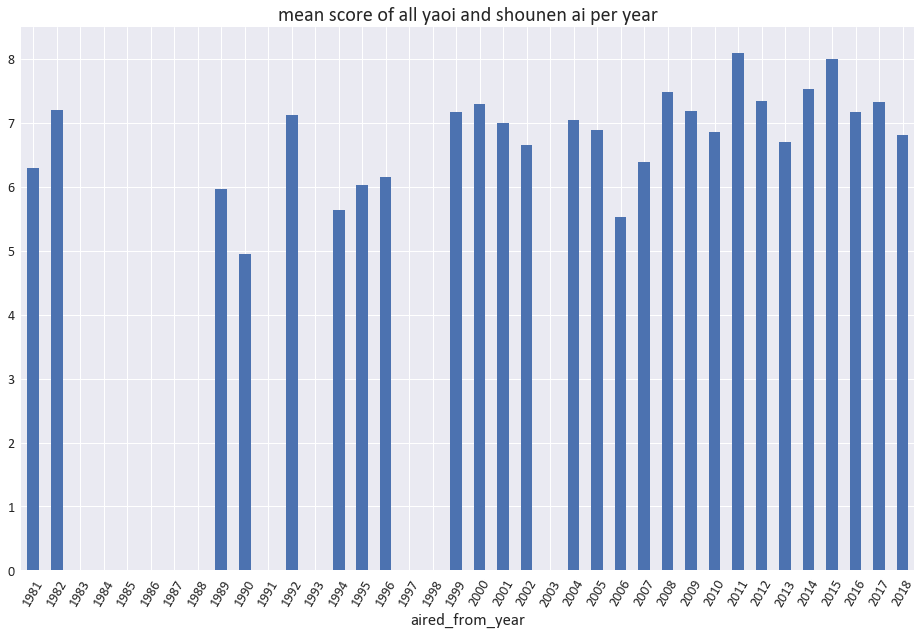

In [24]:
min_year = animelists_genres_years[shonen_ai_or_yaoi_list]['aired_from_year'].min()
max_year = animelists_genres_years[shonen_ai_or_yaoi_list]['aired_from_year'].max()
mean_rating_year = animelists_genres_years[shonen_ai_or_yaoi_list & (animelists_genres_years['my_score'] != 0)].groupby('aired_from_year')['my_score'].mean()
mean_rating_year.index = mean_rating_year.index.astype(np.int)
mean_rating_year = mean_rating_year.reindex(list(range(min_year, max_year + 1)), fill_value=0)
mean_rating_year.sort_index().plot.bar(figsize=(16, 10), title='mean score of all yaoi and shounen ai per year')
plt.xticks(rotation=60)
plt.savefig('graphs-nagat/mean-score-per-year.png', bbox_inches="tight")

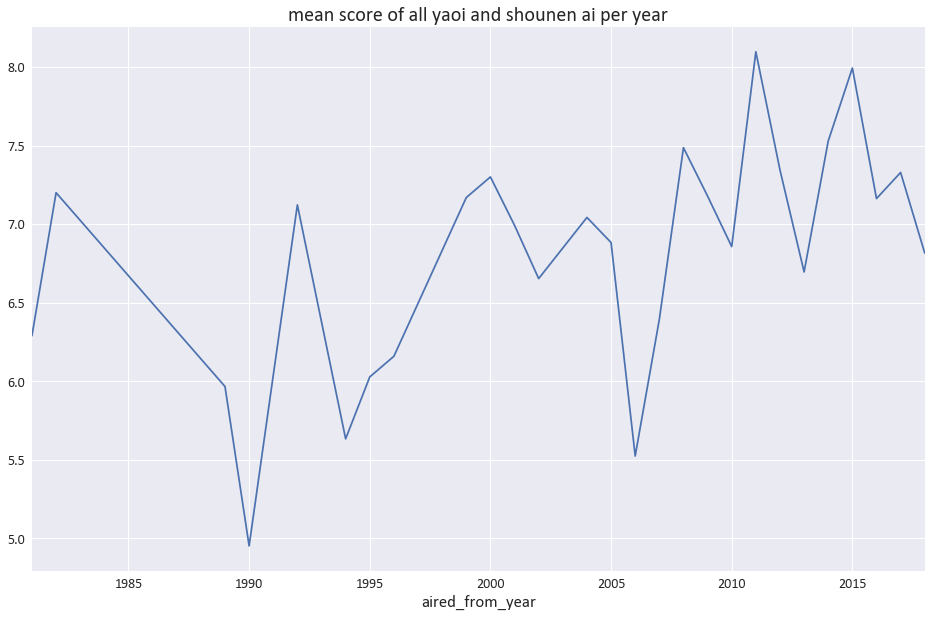

In [25]:
animelists_genres_years[shonen_ai_or_yaoi_list & (animelists_genres_years['my_score'] != 0)].groupby('aired_from_year')['my_score'].mean().sort_index().plot(figsize=(16, 10), title='mean score of all yaoi and shounen ai per year')
plt.savefig('graphs-nagat/mean-score-line-per-year.png', bbox_inches="tight")